In [1]:
%cd ..

/home/alberto/Work/incomplete_multiview_clustering


/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Tutorial: Feature extraction and feature selection on incomplete multi-modal data

## Prerequisites

You’ll need the following libraries installed: matplotlib; seaborn

## Step 1: Import required libraries

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from datasets import LoadDataset
from imvc.decomposition import jNMF
from imvc.preprocessing import MultiViewTransformer, ConcatenateViews
from imvc.ampute import Amputer
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from imvc.impute import get_observed_view_indicator
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from imvc.feature_selection import jNMFFeatureSelector
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches

In [3]:
from tueplots import axes, bundles
plt.rcParams.update(**bundles.icml2022(), **axes.lines())
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key == "legend.fontsize":
        plt.rcParams[key] += 3
    else:
        plt.rcParams[key] += 6

## Step 2: Load the dataset

We'll use the nutrimouse dataset, a multi-view dataset with 40 samples and 2 modalities, to demonstrate how to do a feature selection and dimensionality reduction on block- and feature-wise missing multi-modal data. Each view represents a distinct set of features for the same set of samples.

In [4]:
Xs, y = LoadDataset.load_dataset(dataset_name="nutrimouse", return_y=True)
print("Samples:", len(Xs[0]), "\t", "Modalities:", len(Xs), "\t", "Features:", [X.shape[1] for X in Xs])
y = y.iloc[:,0]
n_clusters = int(y.nunique())
y.value_counts()

Samples: 40 	 Modalities: 2 	 Features: [120, 21]


genotype
1    20
0    20
Name: count, dtype: int64

## Step 3: Apply missing data mechanism (Amputation)

Using Amputer, we randomly introduce missing data to simulate a scenario where some modalities are missing. Here, 30% of the samples will be incomplete.

In [5]:
amputed_Xs = Amputer(p= 0.3, mechanism="mcar", random_state=42).fit_transform(Xs)

You can visualize which modalities are missing using a binary color map.

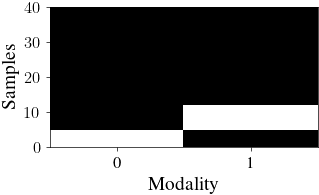

In [6]:
xlabel,ylabel = "Modality", "Samples"
observed_view_indicator = get_observed_view_indicator(amputed_Xs).sort_values(list(range(len(amputed_Xs))))
plt.pcolor(observed_view_indicator, cmap="binary")
plt.xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
_ = plt.xlabel(xlabel), plt.ylabel(ylabel)

## Step 4: Impute missing data 

We are going to apply a pipeline that consists of the following steps: Standardization of the features; Imputation of missing modalities using MOFAImputer, a method designed for multi-view data imputation.

You can again visualize the dataset after imputation to observe the filled modalities.

In [7]:
p = 0.2
amputed_Xs = Amputer(p= p, mechanism="mcar", random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(42).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
n_components = 4

In [8]:
pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                         jNMFFeatureSelector(n_components = n_components, select_by="average", random_state=42,
                                             f_per_component= sum([X.shape[1] for X in Xs])//n_components))
transformed_Xs = pipeline.fit(amputed_Xs)
selected_features = {"Feature": pipeline[-1].selected_features_, "Feature Importance": pipeline[-1].weights_}
selected_features = pd.DataFrame(selected_features).sort_values(by="Feature Importance", ascending= False)
selected_features["Modality"] = selected_features["Feature"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) \
    else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found"))
selected_features = selected_features.groupby("Modality")["Feature Importance"].sum()
selected_features = selected_features.div(selected_features.sum()).mul(100)
selected_features = selected_features.sort_values(ascending=False)
palette = {mod:col for mod, col in zip(selected_features.index, ["#2ca25f", "#99d8c9"])}
selected_features

Modality
Genes          89.628931
Fatty Acids    10.371069
Name: Feature Importance, dtype: float64

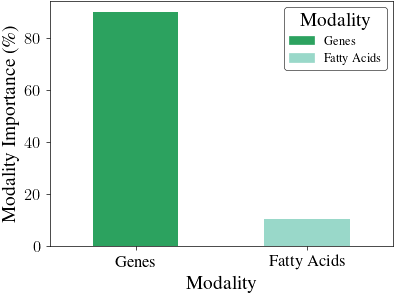

In [9]:
ax = selected_features.plot(kind= "bar", color= list(palette.values()), 
                            figsize= (4, 3), ylabel= "Modality Importance (\%)",
                            rot=0)

handles = [mpatches.Patch(color=color, label=modality) for modality, color in palette.items()]
ax.legend(handles=handles, title="Modality", loc='best')

plt.savefig("paper_figures/expl_mod.pdf")
plt.savefig("paper_figures/expl_mod.svg")

In [10]:
pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                         jNMFFeatureSelector(n_components = n_components, select_by="component", random_state=42))
transformed_Xs = pipeline.fit(amputed_Xs)
selected_features = {"Feature": pipeline[-1].selected_features_, "Feature Importance": pipeline[-1].weights_, "Component": pipeline[-1].component_}
selected_features = pd.DataFrame(selected_features).sort_values(by="Feature Importance", ascending= False)
selected_features["Modality"] = selected_features["Feature"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) \
    else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found"))
selected_features["Component"] += 1
palette_list = [palette[mod] for mod in selected_features["Modality"]]
selected_features

,Feature,Feature Importance,Component,Modality
0,C18.0,3.699040,4,Fatty Acids
1,MDR1,3.531071,2,Genes
2,C16.0,3.250921,1,Fatty Acids
3,Lpin,3.112474,3,Genes


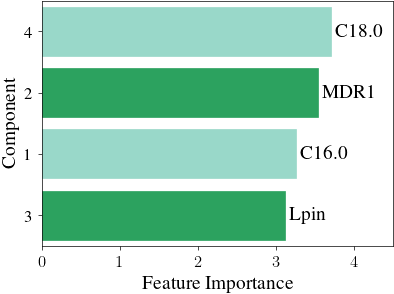

In [11]:
plt.figure(figsize= (4, 3))
ax = sns.barplot(data=selected_features, y="Component", x="Feature Importance",
                 legend=False, orient="h", order= selected_features["Component"],
                 )
ax.set_xlim(0, selected_features["Feature Importance"].max() + .8)

col = 0
for x in ax.properties()['children']:
    if isinstance(x, matplotlib.patches.Rectangle):
        x.set_color(palette_list[col])
        col += 1
    if col == len(selected_features):
        break

for i, container in enumerate(ax.containers):
    ax.bar_label(container, labels=selected_features["Feature"], padding = 3)

plt.savefig("paper_figures/selected_features.pdf")
plt.savefig("paper_figures/selected_features.svg")

In [12]:
pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                         jNMFFeatureSelector(n_components = n_components, select_by="component", random_state=42, f_per_component=3))
transformed_Xs = pipeline.fit(amputed_Xs)
selected_features = {"Feature": pipeline[-1].selected_features_, "Feature Importance": pipeline[-1].weights_, "Component": pipeline[-1].component_}
selected_features = pd.DataFrame(selected_features).sort_values(by=["Component", "Feature Importance"], ascending= [True, False])
selected_features["Modality"] = selected_features["Feature"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) \
    else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found"))
selected_features["Hue"] = list(range(selected_features["Component"].max())) * pipeline[-1].n_components
selected_features["Component"] += 1
selected_features

,Feature,Feature Importance,Component,Modality,Hue
2,C16.0,3.250921,1,Fatty Acids,0
7,ACAT2,2.852038,1,Genes,1
11,C18.1n.9,2.621197,1,Fatty Acids,2
1,MDR1,3.531071,2,Genes,0
4,RARa,3.526839,2,Genes,1
8,OCTN2,2.998118,2,Genes,2
3,Lpin,3.112474,3,Genes,0
6,TRb,2.986583,3,Genes,1
10,apoA.I,2.696877,3,Genes,2
0,C18.0,3.699040,4,Fatty Acids,0


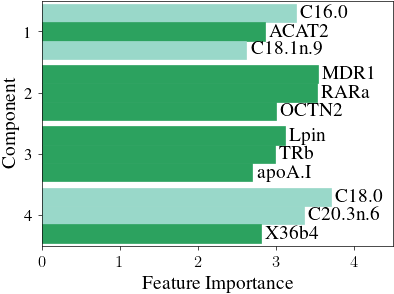

In [13]:
plt.figure(figsize= (4, 3))
ax = sns.barplot(data=selected_features, y="Component", x="Feature Importance",
                 hue="Hue", legend=False, orient="h", width= .9,
                 )

ax.set_xlim(0, selected_features["Feature Importance"].max() + .8)

selected_features = selected_features.sort_values("Hue")
col = 0
for i, x in enumerate(ax.properties()['children']):
    if isinstance(x, matplotlib.patches.Rectangle):
        x.set_color(palette[selected_features["Modality"].iloc[col]])
        col += 1
    if col == len(selected_features):
        break

for i, container in enumerate(ax.containers):
    ax.bar_label(container, labels=selected_features[selected_features["Hue"] == i]["Feature"],
                 padding = 3)

plt.savefig("paper_figures/expl_features.pdf")
plt.savefig("paper_figures/expl_features.svg")

## Step 5: Evaluate the imputation performance

We will calculate the Mean Squared Error (MSE) between the true values (before amputation) and the imputed values, restricted to the places where data were missing. The MSE helps quantify how well the imputation was performed. In addition to the MOFA-based pipeline, we introduce a baseline imputation method that uses SimpleImputer to fill in missing values with the average.

Define a range of missingness proportions (ps), and vary the number of components for MOFAImputer (n_components_list). We will generate both block- and feature-wise missing data, and perform multiple runs for robustness.

In [5]:
ps = np.arange(0, 0.9, 0.2)
n_components_list = [1, 2, 4, 8, 16]
n_times = 50
algorithms = ["Dimensionality reduction", "Feature selection", "Random features", "All features"]
mechanisms = ["um", "pm", "mcar", "mnar"]
all_metrics = {}

In [6]:
for algorithm in tqdm(algorithms):
    all_metrics[algorithm] = {}
    for mechanism in tqdm(mechanisms):
        all_metrics[algorithm][mechanism] = {}
        for n_components in n_components_list:
            all_metrics[algorithm][mechanism][n_components] = {}
            for p in ps:
                missing_percentage = int(p*100)
                all_metrics[algorithm][mechanism][n_components][missing_percentage] = {}
                for i in range(n_times):
                    all_metrics[algorithm][mechanism][n_components][missing_percentage][i] = {}
                    Xs_train = Amputer(p= p, random_state=i).fit_transform(Xs)
                    for X in Xs_train:
                        X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
                    if algorithm == "Dimensionality reduction":
                        pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                                 jNMF(n_components = n_components, random_state=i),
                                                 )
                    elif algorithm == "Feature selection":
                        pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                                 jNMFFeatureSelector(n_components = n_components, random_state=i),
                                                 FunctionTransformer(lambda x: np.concatenate(x, axis=1)),
                                                 SimpleImputer(),
                                                 )
                    elif algorithm == "Random features":
                        pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                                 ConcatenateViews(),
                                                 SimpleImputer().set_output(transform="pandas"),
                                                 FunctionTransformer(lambda x: 
                                                                     x.iloc[:,np.random.default_rng(i).integers(0,
                                                                                                                sum([X.shape[1] for X in Xs_train]),
                                                                                                                size= n_components)]),
                         )
                    elif algorithm == "All features":
                        pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                                 ConcatenateViews(),
                                                 SimpleImputer().set_output(transform="pandas"),
                         )
                    try:
                        transformed_X = pipeline.fit_transform(Xs_train)
                        preds = SVC(random_state=i).fit(transformed_X, y).predict(transformed_X)
                        metric = accuracy_score(y_pred=preds, y_true=y)
                        all_metrics[algorithm][mechanism][n_components][missing_percentage][i]["Accuracy"] = metric
                        all_metrics[algorithm][mechanism][n_components][missing_percentage][i]["Comments"] = ""
                    except Exception as ex:
                        all_metrics[algorithm][mechanism][n_components][missing_percentage][i]["Comments"] = ex

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
flattened_data = [
    {
        'Method': algorithm,
        'Mechanism': mechanism,
        'Missing rate (\%)': p,
        'Components': n_components,
        'Iteration': i,
        **iter_dict
    }
    for algorithm, algorithm_dict in all_metrics.items()
    for mechanism, mechanism_dict in algorithm_dict.items()
    for n_components, n_components_dict in mechanism_dict.items()
    for p, p_dict in n_components_dict.items()
    for i, iter_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df['Method'] = pd.Categorical(df['Method'], categories=["Dimensionality reduction", "Feature selection", "All features", "Random features"], ordered=True)
df = df.sort_values(["Method", "Mechanism", "Missing rate (\%)", "Components", "Iteration"], ascending=[True, False, True, True, True])
df.to_csv("tutorials/reduction_results.csv", index= None)
print(df.shape)
df.head()

(20000, 7)


,Method,Mechanism,Missing rate (\%),Components,Iteration,Accuracy,Comments
0,Dimensionality reduction,um,0,1,0,0.6,
1,Dimensionality reduction,um,0,1,1,0.6,
2,Dimensionality reduction,um,0,1,2,0.6,
3,Dimensionality reduction,um,0,1,3,0.6,
4,Dimensionality reduction,um,0,1,4,0.6,


In [37]:
df = pd.read_csv("tutorials/reduction_results.csv")
df

,Method,Mechanism,Missing rate (\%),Components,Iteration,Accuracy,Comments
0,Dimensionality reduction,um,0,1,0,0.600,NaN
1,Dimensionality reduction,um,0,1,1,0.600,NaN
2,Dimensionality reduction,um,0,1,2,0.600,NaN
3,Dimensionality reduction,um,0,1,3,0.600,NaN
4,Dimensionality reduction,um,0,1,4,0.600,NaN
...,...,...,...,...,...,...,...
19995,Random features,mcar,80,16,45,0.875,NaN
19996,Random features,mcar,80,16,46,0.800,NaN
19997,Random features,mcar,80,16,47,NaN,positional indexers are out-of-bounds
19998,Random features,mcar,80,16,48,NaN,positional indexers are out-of-bounds


In [38]:
errors = df[df["Comments"].notnull()]
print("errors", errors.shape)
errors

errors (192, 7)


,Method,Mechanism,Missing rate (\%),Components,Iteration,Accuracy,Comments
16059,Random features,um,80,2,9,NaN,positional indexers are out-of-bounds
16101,Random features,um,80,4,1,NaN,positional indexers are out-of-bounds
16108,Random features,um,80,4,8,NaN,positional indexers are out-of-bounds
16109,Random features,um,80,4,9,NaN,positional indexers are out-of-bounds
16134,Random features,um,80,4,34,NaN,positional indexers are out-of-bounds
...,...,...,...,...,...,...,...
19992,Random features,mcar,80,16,42,NaN,positional indexers are out-of-bounds
19994,Random features,mcar,80,16,44,NaN,positional indexers are out-of-bounds
19997,Random features,mcar,80,16,47,NaN,positional indexers are out-of-bounds
19998,Random features,mcar,80,16,48,NaN,positional indexers are out-of-bounds


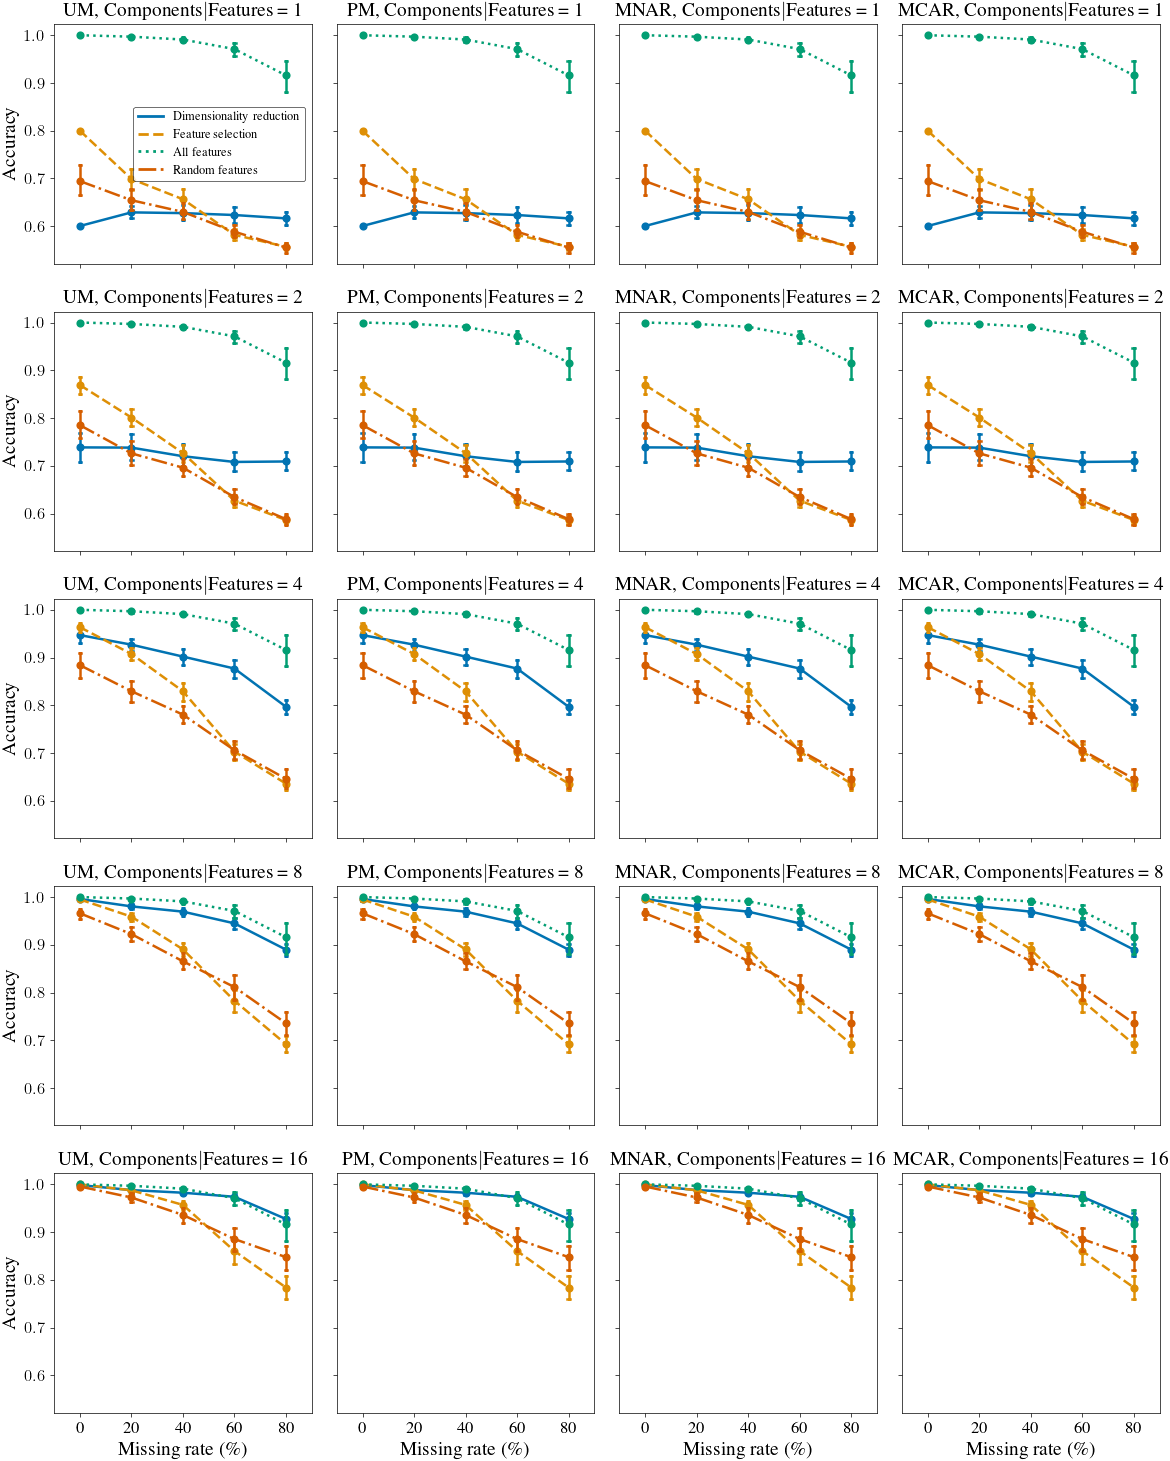

In [39]:
mechanism_names = {"um": "Unpaired missing", "pm": "Partial missing", "mnar": "Missing not at random", "mcar": "Missing completely at random"}
colorblind_palette = sns.color_palette("colorblind")
g = sns.FacetGrid(data=df, col="Mechanism", row="Components", despine=False).map_dataframe(sns.pointplot, x="Missing rate (\%)", y="Accuracy", hue="Method",
                                                                          linestyles=["-", "--", ":", "-."], capsize= 0.05, 
                                                                          seed= 42, palette=colorblind_palette)
handles = [plt.Line2D([0], [0], color=col, lw=2, linestyle=linestyle)
                  for col,linestyle in zip(colorblind_palette, ["-", "--", ":", "-."])]
g.axes[0][0].legend(handles=handles, labels=df["Method"].unique().tolist(), loc= "best")

# for ax,n_components in zip(g.axes.flatten(), n_components_list):
for axes,n_components in zip(g.axes, df["Components"].unique()):
    for ax,mechanism in zip(axes, df["Mechanism"].unique()):
        ax.set_title(f"{mechanism.upper()}, Components\(|\)Features = {n_components}")

plt.tight_layout()
plt.savefig("paper_figures/selection_results_comps.pdf")
plt.savefig("paper_figures/selection_results_comps.svg")

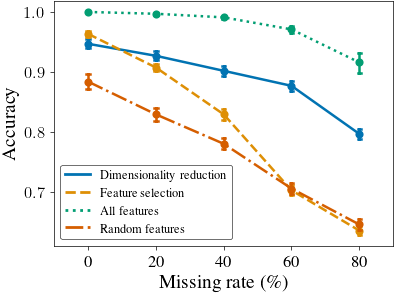

In [27]:
plt.figure(figsize= (4, 3))
ax = sns.pointplot(data=df[df["Components"] == n_components], x="Missing rate (\%)", y="Accuracy", hue="Method", linestyles=["-", "--", ":", "-."],
              capsize= 0.05, seed= 42, palette=colorblind_palette, legend=False)

handles = [plt.Line2D([0], [0], color=col, lw=2, linestyle=linestyle)
                  for col,linestyle in zip(colorblind_palette, ["-", "--", ":", "-."])]
ax.legend(handles=handles, labels=df["Method"].unique().tolist(), loc= "best")

plt.savefig("paper_figures/selection_results.pdf")
plt.savefig("paper_figures/selection_results.svg")